### Откройте файл с данными и изучите общую информацию.

Начинаю, как водится, с подключения библиотек.

Открываю файл

In [ ]:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn
import numpy as np

In [ ]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

Смотрю общую информацию о файле

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Зная общее количество строк датафрейма, посчитаю два значения. 5% - несущественное количество, которым можно принебречь. Начиная от 10%, считаю количество заслуживающим внимания.

In [ ]:
for i in [5,10]:
    print(i, '% это', int(len(data)*i/100),'строк датафрейма')

5 % это 1184 строк датафрейма
10 % это 2369 строк датафрейма


Итого, видно, что ряд столбцов содержит очень много нулевых значений. Посмотрим, будет влиять это на анализ или нет.

Столбец "расстояние до центра" содержит верхний регистр. Переведу в нижний регистр и в змеиный стиль.

In [ ]:

data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})

Взгляну на датафрейм

In [ ]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Построю общую гистограмму для всех числовых столбцов таблицы.

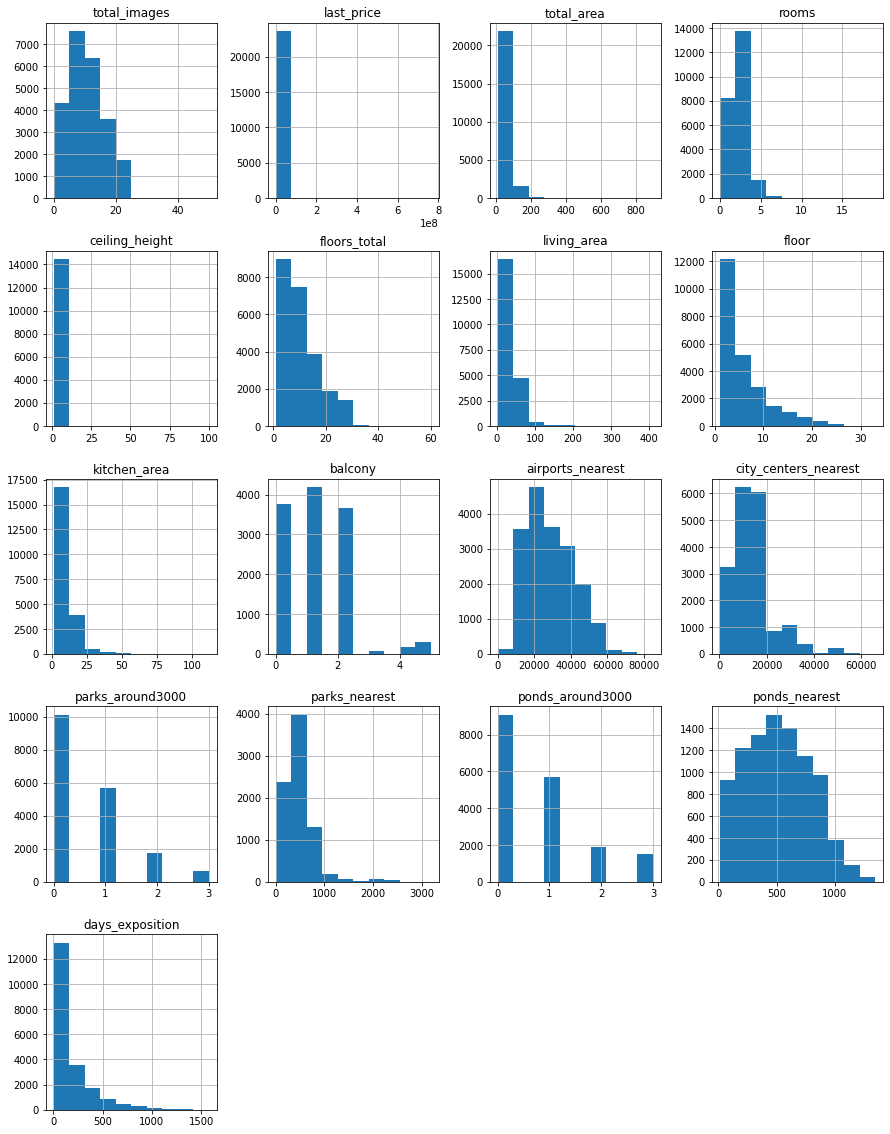

In [ ]:
data.hist(figsize=(15,20));

Предварительный этап знакомства с файлом закончен. Увидел его размеры, содеримое. Ознакомился с количеством "пустых" значению. Приступаю к предобработке данных.

### Предобработка данных

Посчитаю количество пропусков в столбцах.

In [ ]:
print (data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


**Итого получается:**

9195 пропусков в столбце ceiling_height -  в более, чем трети объявлений пропущена высота потолков, оставим Null. Заменять на что-то смысла не имеет. Медиана или среднее не будут отражать реальное положение дел.

86 пропусков в столбце floors_total - оставим Null, данные, возможно, просто не заполнили.

1903 пропусков в столбце living_area - заполним значениями, рассчитанным по среднему коэффициенту соотношения между жилой и общей площадью.

20924 пропусков в столбце is_apartment - здесь проще. В строка с проусками ставим False - предполагаем, что это не апартаменты.

2278 пропусков в столбце kitchen_area - заполним значениями, рассчитанным по среднему коэффициенту соотношения между кухней и общей площадью.

11519 пропусков в столбце balcony - скорее всего там нет балконов, заполняем 0.

49 пропусков в столбце locality_name - данные просто не заполнили, оставим Null.

5542 пропусков в столбце airports_nearest - аэропортов рядом нет, оставляем Null.

5519 пропусков в столбце city_centers_nearest - центр города не близко, оставляем Null.

5518 пропусков в столбце parks_around3000 - парков нет в радиусе 3км, оставляем Null.

15620 пропусков в столбце parks_nearest - парков нет, оставляем Null.

5518 пропусков в столбце ponds_around3000 - значит прудов нет в радиусе 3км, оставляем Null.

14589 пропусков в столбце ponds_nearest - оставляем Null.

3181  пропусков в столбце days_exposition - объявление не было опубликовано, оставляем Null.

In [ ]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')
        );
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

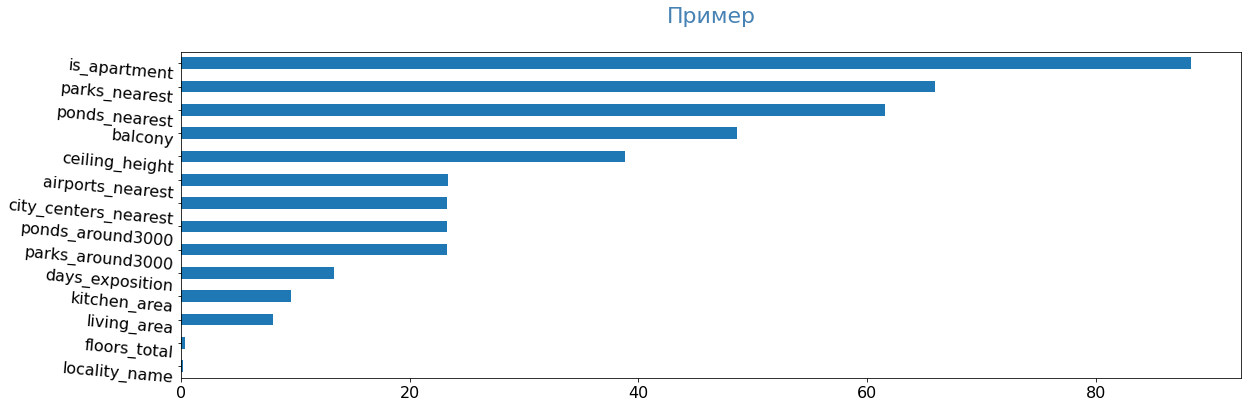

In [ ]:
pass_value_barh(data)

**Заполняю нулями пропуски в "балконах"**

In [ ]:
data['balcony'] = data['balcony'].fillna(0)

**Заполняю пропуски в столбце Апартаменты**

In [ ]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Предполагаю, что площадь кухни не указана, если она не является отдельной: в квартирах со свободной планировкой и в квартирах-студиях. Площадь кухни в этом случае входит в состав общей жилой площади.

In [ ]:
data['kitchen_area'].where((data['kitchen_area'].isna()) & (data['studio']),0)
data['kitchen_area'].where((data['kitchen_area'].isna()) & (data['open_plan']),0)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
23694    0.0
23695    0.0
23696    0.0
23697    0.0
23698    0.0
Name: kitchen_area, Length: 23699, dtype: float64

Где-то указана общая площадь объекта недвижимости, но не указано распределение на жилую/нежилую, и площадь кухни. Для таких объявлений заполним отсутствующую информацию медианными значениями, через коэфициент, отражающий медианную долю кухни/жилой площади в общей площади квартиры

In [ ]:
#К-т доли жилой площади в общей площади квартиры (рассчитанный по медианным значениям):
k_median_living_area = data['living_area'].median() / data['total_area'].median()
#К-т доли площади кухни в общей площади квартиры (рассчитанный по медианным значениям):
k_median_kitchen_area = data['kitchen_area'].median() / data['total_area'].median()

Применим коэффициенты

In [ ]:
data['living_area'] = data['living_area'].fillna(k_median_living_area*data['total_area'])
data['kitchen_area'] = data['kitchen_area'].fillna(k_median_kitchen_area*data['total_area'])

In [ ]:
try:
    data['total_area']*0,9 <= (data['living_area'] + data['kitchen_area'])
    print('ok')
except:
    print('что-то не так')

ok


In [ ]:
data.query ('total_area*0.9 <= (living_area + kitchen_area)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
41,16,7900000.0,74.0,2016-05-04T00:00:00,3,NaN,14.0,59.00,8,False,...,12.0000,5.0,Санкт-Петербург,37715.0,12612.0,1.0,725.0,1.0,759.0,179.0
171,6,3800000.0,49.0,2019-02-22T00:00:00,2,2.50,9.0,38.00,8,False,...,10.0000,1.0,посёлок Шушары,18471.0,24272.0,0.0,NaN,0.0,NaN,11.0
184,7,2600000.0,30.2,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,False,...,6.2000,0.0,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
220,8,3890000.0,37.0,2018-07-09T00:00:00,1,2.50,25.0,28.00,6,False,...,9.0000,0.0,Санкт-Петербург,25408.0,16166.0,0.0,NaN,0.0,NaN,28.0
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,NaN,NaN,20.75,1,False,...,4.9175,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23297,10,1850000.0,48.2,2019-03-13T00:00:00,2,NaN,5.0,42.20,2,False,...,6.0000,1.0,Высоцк,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23328,12,4299000.0,54.0,2016-11-25T00:00:00,2,NaN,14.0,40.00,8,False,...,10.0000,0.0,Колпино,25612.0,31399.0,0.0,NaN,0.0,NaN,343.0
23521,13,8500000.0,65.0,2018-11-01T00:00:00,2,NaN,4.0,44.00,2,False,...,15.3000,0.0,Санкт-Петербург,22276.0,3996.0,1.0,627.0,0.0,NaN,NaN
23579,7,2350000.0,24.8,2018-06-07T00:00:00,1,NaN,10.0,18.00,2,False,...,4.3400,0.0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,89.0


**662 строки, около 3%. Таким количеством можно принебречь**

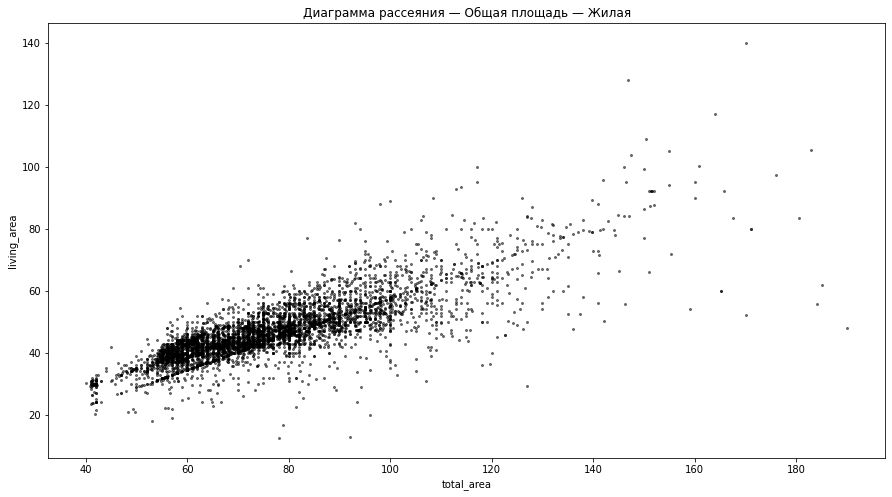

In [ ]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='living_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'black', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Жилая');

Рассмотрим параметр ceiling_height, видим что есть необоснованно большие значения но пока оставим их как есть,
медиана от среднего отличается не сильно из-за этих выбросов во всей выборке

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
18545,6,3750000.0,43.0,2019-03-18T00:00:00,2,25.0,5.0,29.0,3,False,...,7.525,0.0,Санкт-Петербург,27054.0,8033.0,1.0,540.0,0.0,NaN,12.0
355,17,3600000.0,55.2,2018-07-12T00:00:00,2,25.0,5.0,32.0,2,False,...,9.660,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
6246,6,3300000.0,44.4,2019-03-25T00:00:00,2,25.0,5.0,31.3,5,False,...,5.700,0.0,Кронштадт,68923.0,50649.0,1.0,417.0,2.0,73.0,NaN
14382,9,1700000.0,35.0,2015-12-04T00:00:00,1,25.0,5.0,20.0,2,False,...,8.000,1.0,поселок Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,206.0
11285,0,1950000.0,37.0,2019-03-20T00:00:00,1,25.0,5.0,17.0,4,False,...,9.000,2.0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,18.0
4643,0,4300000.0,45.0,2018-02-01T00:00:00,2,25.0,9.0,30.0,2,False,...,7.000,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
9379,5,3950000.0,42.0,2017-03-26T00:00:00,3,25.0,5.0,30.0,2,False,...,5.200,0.0,Санкт-Петербург,11647.0,13581.0,0.0,NaN,0.0,NaN,NaN
5669,4,4400000.0,50.0,2017-08-08T00:00:00,2,26.0,9.0,21.3,3,False,...,7.000,2.0,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
5807,17,8150000.0,80.0,2019-01-09T00:00:00,2,27.0,36.0,41.0,13,False,...,12.000,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
5246,0,2500000.0,54.0,2017-10-13T00:00:00,2,27.0,5.0,30.0,3,False,...,9.000,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0


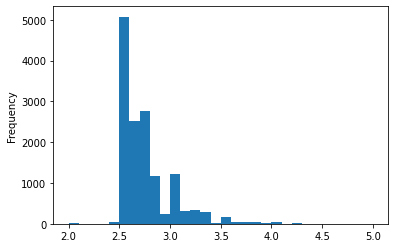

In [ ]:
data['ceiling_height'].sort_values().plot(y = 'ceiling_height', kind = 'hist', bins = 30, range=(2,5))
data['ceiling_height'].value_counts()
data['ceiling_height'].describe()
data[data['ceiling_height'] > 4].sort_values('ceiling_height').tail(20)

Изменим тип данных для:

- last_price - int
- first_day_exposition - date
- balcony - int
- floors_total - int
- days_exposition - int

Использую try-except чтобы отловить ошибки при преобразовании типов

In [ ]:
try:
    data['last_price'] = data['last_price'].astype('int')
    print('ok')
except:
    print('last_price int type conversion fail')
data['last_price']

ok


0        13000000
1         3350000
2         5196000
3        64900000
4        10000000
           ...   
23694     9700000
23695     3100000
23696     2500000
23697    11475000
23698     1350000
Name: last_price, Length: 23699, dtype: int64

Перевожу формат 'first_day_exposition' в датавремя

In [ ]:
try:
    data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')
    print('ok')
except:
    print('first_day_exposition to_datetime type conversion fail')

ok


Столбец балкон

In [ ]:
try:
    data['balcony'] = data['balcony'].astype('int')
    print('ok')
except:
    print('balcony int type conversion fail')

ok


Общее число этажей

In [ ]:
try:
    data['floors_total'] = data['floors_total'].astype('Int8')
    print('ok')
except:
    print('floors_total int type conversion fail')

ok


И срок размещения объявления

In [ ]:
try:
    data['days_exposition'] = np.floor(pd.to_numeric(data['days_exposition'], errors='coerce')).astype('int')
    print('ok')
except:
    print('days_exposition int type conversion fail')

days_exposition int type conversion fail


В living_area слишком много знаков после запятой и есть пропущенные значения,
можно посчитать средний процент жилой площади от всей площади по всей выборке
и высчитать для строк с пропусками жилую площадь как вариант но мы не будем тратить на это время.

In [ ]:
data['living_area'].value_counts()
data['living_area'].describe()

count    23699.000000
mean        34.624296
std         22.381873
min          2.000000
25%         19.000000
50%         30.000000
75%         42.173077
max        409.700000
Name: living_area, dtype: float64

**Изучим уникальные значения населённых пунктов**

In [ ]:
def loc_length():
    return print('Количество уникальных занчений locality_name:', data['locality_name'].unique().shape[0])
loc_length()

Количество уникальных занчений locality_name: 365


Приводим всё к нижнему регистру

In [ ]:
data['locality_name'] = data['locality_name'].str.lower()

Сменим ё на е

In [ ]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
loc_length()
print()

Количество уникальных занчений locality_name: 331



Заменяем "городской поселок" на "поселок городского типа"

In [ ]:
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')
loc_length()
print()

Количество уникальных занчений locality_name: 324



In [ ]:
# check
data.locality_name.nunique()

323

Проверим наличие явных дубликатов

In [ ]:
print('Количетво явных дубликатов:', data.duplicated().sum())

Количетво явных дубликатов: 0


**Устранение выбросов**

In [ ]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,23699.000000,23699.000000,23699.000000,23699.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.624296,5.892358,10.505495,0.591080,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.381873,4.885249,6.039401,0.959298,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,19.000000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.173077,8.000000,12.000000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


**total_images** - не трогаем.

**last_price** - квартиры от 0 до 20 млн, нет квартир стоимостью 0.
Есть одна квартира стоимостью меньше 100 тыс, её мы учитывать не будем.
225 квартир стоимостью меньше 1 млн - не похоже на выброс, оставляем.
Убираем слишком дорогие квартиры стоимостью больше 100 млн.

In [ ]:
print('Квартир стоимостью 0:', data.query('last_price == 0')['last_price'].count())
print('Квартир стоимостью меньше 100 тыс:', data.query('last_price < 1e+05')['last_price'].count())
print('Квартир стоимостью больше 100 млн:', data.query('last_price > 1e+08')['last_price'].count())
data.drop(index=data.query('last_price > 1e+08').index,inplace=True)

Квартир стоимостью 0: 0
Квартир стоимостью меньше 100 тыс: 1
Квартир стоимостью больше 100 млн: 37


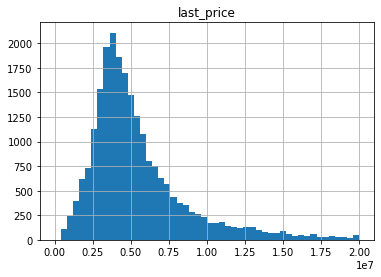

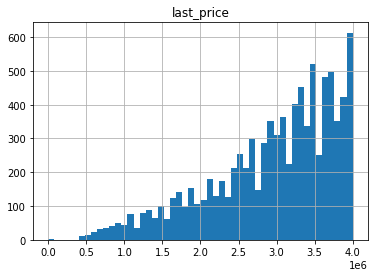

In [ ]:
data.hist('last_price', bins=50, range=(0,2e+07));
data.hist('last_price', bins=50, range=(0,4e+06));
data.drop(index=data.query('last_price < 1e+05').index,inplace=True)

**total_area** - нет квартир площадью меньше 10 кв.м., но есть меньше 20.
Это не похоже на аномалию.
Квартиры с площадью более 500 кв.м., видимо, элитная недвижимость, их немного и лучше удалить.

Квартир площадью менее 10 кв.м.: 0
Квартир площадью более 500 кв.м.: 3


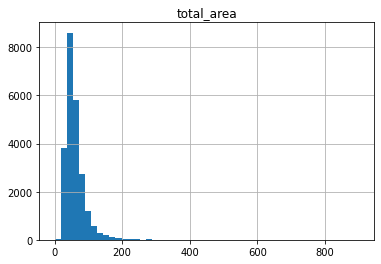

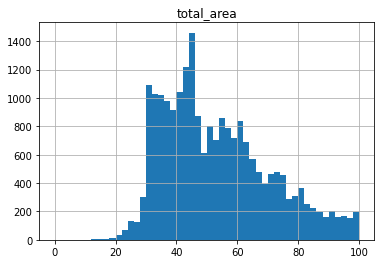

In [ ]:
print('Квартир площадью менее 10 кв.м.:',data.query('total_area < 10')['total_area'].count())
print('Квартир площадью более 500 кв.м.:',data.query('total_area > 500')['total_area'].count())

data.drop(index=data.query('total_area > 500').index,inplace=True)

data.hist('total_area', bins=50, range=(0,900));
data.hist('total_area', bins=50, range=(0,100));

**rooms** - есть нулевые значения, 195.
Студии, апартаменты или свободная планировка...

In [ ]:
print('Квартиры без комнат:',data.query('rooms == 0')['rooms'].count())

print('Квартиры без комнат и студии:',data.query('rooms == 0 and studio')['rooms'].count())

print('Квартиры без комнат и апартаменты:',data.query('rooms == 0 and is_apartment')['rooms'].count())

print('Квартиры без комнат и свободная планировка:',data.query('rooms == 0 and open_plan')['rooms'].count())

print('Квартиры без комнат не апартаменты и не свободная планировка:',data.query('rooms == 0 and ~open_plan and ~studio')['rooms'].count())

data.drop(index=data.query('rooms > 7').index,inplace=True)

Квартиры без комнат: 197
Квартиры без комнат и студии: 138
Квартиры без комнат и апартаменты: 0
Квартиры без комнат и свободная планировка: 59
Квартиры без комнат не апартаменты и не свободная планировка: 0


Похоже так и есть. Квартиры без комнат не апартаменты и не свободная планировка - 0. Максимальное значение аж 19 комнат, но такое тоже бывает.

**ceiling_height** - высота потолков.
В жилых домах устанавливается с учетом минимальных требований и комфортного пребывания в нем.
Независимо от года постройки и от типа здания, высота от пола до потолка должна быть в пределах 2,5-3,2 метров.
При изучении недвижимости известны только небольшое количество сверхдорогих двухэтажнх пентхаусов с высотой потолков 4-5м.
Можно предположить, что квартиры с высотой потолков 25-36м на самом деле являются опечаткой и соотвествуют 2.5-3.6м
Исходя их этого предполагаем, что все квартиры с высотой потолков от 36м являются выбросами.
Более того есть одно значение, которое показывает высоту потолков выше 50м.

In [ ]:
print('Квартир с потолками от 4 до 5м: ' + str(data.query('ceiling_height > 4 and ceiling_height <= 5')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 5 до 25м: ' + str(data.query('ceiling_height > 5 and ceiling_height < 25')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 25м до 36м: ' + str(data.query('ceiling_height >= 25 and ceiling_height <= 36')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 25м до 36м: ' + str(data.query('ceiling_height > 36 and ceiling_height < 50')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 50м: ' + str(data.query('ceiling_height >= 50')['ceiling_height'].count()) + ' шт.')

Квартир с потолками от 4 до 5м: 36 шт.
Квартир с потолками от 5 до 25м: 14 шт.
Квартир с потолками от 25м до 36м: 19 шт.
Квартир с потолками от 25м до 36м: 0 шт.
Квартир с потолками от 50м: 1 шт.


Удаляем квартиры с высотой потолков от 4 до 25метров.
Для квартир с высотой потолков до 25 до 36 метров предполагаем, что это опечатка и делим на 10, получая 2.5 и 3.6 метра.
Удаляем квартиры с высотой потолков от 36 метров.

In [ ]:
data.drop(index=data.query('ceiling_height > 4 and ceiling_height < 25').index,inplace=True)

data.update(data[(data['ceiling_height'] >= 25) & (data['ceiling_height'] <= 36)]['ceiling_height']/10)

data.drop(index=data.query('ceiling_height > 36').index,inplace=True)

Смотрим на высоту полтолков менее 2.5м более внимательно.

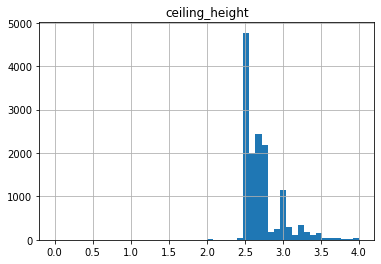

In [ ]:
data.hist('ceiling_height',bins=50,range=(0,4));

Нас не интересуют квартиры с высотой потолков менее 2.5м. Удаляем из выборки.

In [ ]:
print('Квартир с потолками меньше 2.5м : ' + str(data.query('ceiling_height < 2.5')['ceiling_height'].count()) + ' шт.')

data.drop(index=data.query('ceiling_height < 2.5').index,inplace=True)

Квартир с потолками меньше 2.5м : 73 шт.


**floors_total** - Есть одноэтажные квартиры,но это не похоже на выброс. Так же есть небольшое количество квартир в 30 и более этажных домах.

Квартир в одноэтажных домах :  23
Квартир в 30+ этажных домах :  31


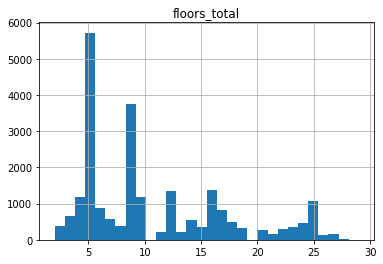

In [ ]:
print('Квартир в одноэтажных домах : ',data.query('floors_total == 1')['floors_total'].count())
print('Квартир в 30+ этажных домах : ',data.query('floors_total > 30')['floors_total'].count())

data.drop(index=data.query('floors_total > 30').index,inplace=True)
data.drop(index=data.query('floors_total == 1').index,inplace=True)
data.hist('floors_total', bins=30);

**living_area**

Жилая площадь меньше 10 кв.м.:  31
Жилая площадь больше общей:  0
Жилая площадь больше 200:  20


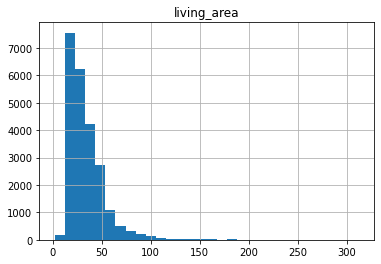

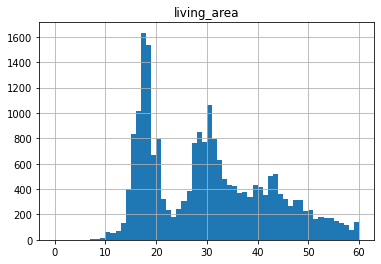

In [ ]:
print('Жилая площадь меньше 10 кв.м.: ',data.query('living_area < 10')['living_area'].count())
print('Жилая площадь больше общей: ',data.query('living_area > total_area')['living_area'].count())
print('Жилая площадь больше 200: ',data.query('living_area > 200')['living_area'].count())
data.hist('living_area', bins=30);
data.hist('living_area', bins=60, range=(0,60));



- Имеем большое количество квартир с жилой площадью от 10 до 60 кв.м.
Здесь интерсуют квартиры с жилой площадью меньше 10 кв.м. их 25!
Судя по гистограмме есть даже с с жилой площадью 2 кв.м.
Скорее всего опечатка в площади.
Отбросим значения с жилой площадью меньше 10кв.м.
Отбросим квартиры с площадью более 200 кв.м.

In [ ]:
data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area > 200').index,inplace=True)

**floor** - этаж. Здесь нет нулевых значений и слишком больших значений.
Проверим, есть ли значения этажа больше, чем этажность строения.

Этаж 0 0
Этаж 0 0
Этаж больше количества этажей:  0


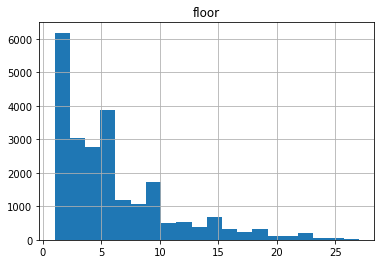

In [ ]:
print('Этаж 0',data.query('floor == 0')['floor'].count())

print('Этаж 0',data.query('floor > 30')['floor'].count())

print('Этаж больше количества этажей: ',data.query('floor > floors_total')['floor'].count())

data.hist('floor',bins=20);

**kitchen_area** - площадь кухни. Здесь есть одна квартира с площадью кухни меньше 1 кв. метра. Явно аномалия.
Немало кухонь с площадью 5 кв.м. Кухонь с площадью более 30 кв.м. довольно мало.

Удаляем строки с кухнами менее 2кв.м. и больше 50кв.м.

Площадь кухни меньше 2 кв.м.:  1
Площадь кухни 5 кв.м.:  356
Площадь кухни больше 50 кв.м.:  36
Площадь кухни больше общей:  0


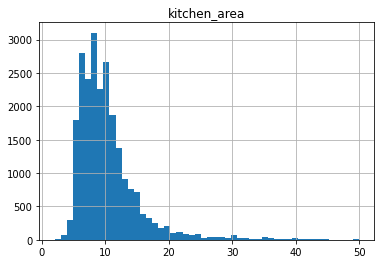

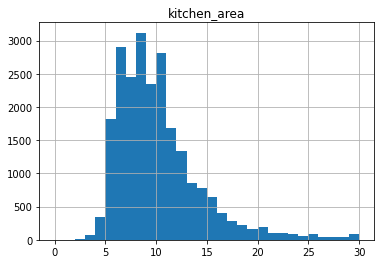

In [ ]:
print('Площадь кухни меньше 2 кв.м.: ',data.query('kitchen_area < 2')['living_area'].count())
print('Площадь кухни 5 кв.м.: ',data.query('kitchen_area == 5')['living_area'].count())
print('Площадь кухни больше 50 кв.м.: ',data.query('kitchen_area > 50')['living_area'].count())
print('Площадь кухни больше общей: ',data.query('kitchen_area > total_area')['living_area'].count())

data.drop(index=data.query('kitchen_area < 2').index,inplace=True)
data.drop(index=data.query('kitchen_area > 50').index,inplace=True)

data.hist('kitchen_area', bins=50);
data.hist('kitchen_area', bins=30, range=(0,30));

**balcony** - не трогаем.

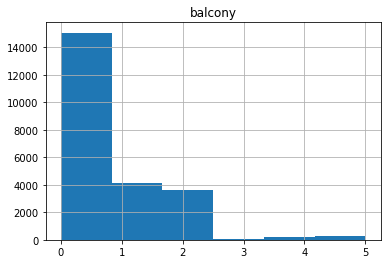

In [ ]:
data.hist('balcony', bins=6);

**days_exposition** - сколько дней было размещено объявление видим, что в целом график нормальный. Нулевых значений нет. Объявления, которые висели дольше 3-х лет отбросим.

Объявление не было оопубликовано:  0
Объявлению больше 3 лет :  165


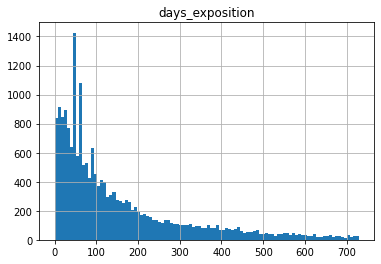

In [ ]:
print('Объявление не было оопубликовано: ',data.query('days_exposition == 0')['days_exposition'].count())

print('Объявлению больше 3 лет : ',data.query('days_exposition > 365*3')['days_exposition'].count())

data.drop(index=data.query('days_exposition > 365*3').index,inplace=True)

data.hist('days_exposition', bins=100, range = (0, 730));

- airports_nearest
- city_centers_nearest
- parks_around3000
- parks_nearest
- ponds_around3000
- ponds_nearest
Эти данные собраны автоматизированно. По гистограммам выглядят нормально. Выбивается одна строчка с airports_nearest. Квартир ближе 5 км к аэропорту одна, она похоже располагается в аэропорту. Её надо удалить. остальные данные нормальные.

Квартир слишком близко к аэропорту: 1


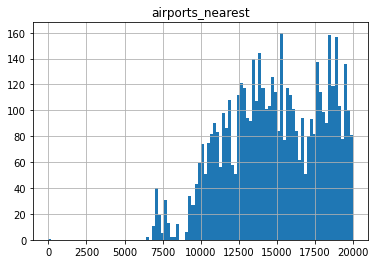

In [ ]:
print('Квартир слишком близко к аэропорту:',data.query('airports_nearest < 5000')['airports_nearest'].count())
data.hist('airports_nearest', bins=100, range=(0,20000));

data.drop(index=data.query('airports_nearest < 5000').index,inplace=True)

Cбросим индексацию после удаления строк.

In [ ]:
data.reset_index(drop=True,inplace=True)

Показатели о кол-ве объявлений в дата-файле, минимальных и максимальных показателях в выбранных параметрах о продаже квартир, сырые данные.

In [ ]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max', 'median'])
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,199.00","23,199.00","14,128.00","20,077.00","23,199.00","23,199.00","23,199.00","23,199.00","23,115.00"
min,0.00,12.00,2.50,1.00,"430,000.00",10.00,2.00,1.00,2.00
max,7.00,413.50,4.00,"1,095.00","99,000,000.00",200.00,50.00,27.00,29.00
median,2.00,52.00,2.65,93.00,"4,600,000.00",30.00,9.00,4.00,9.00


#### check gap

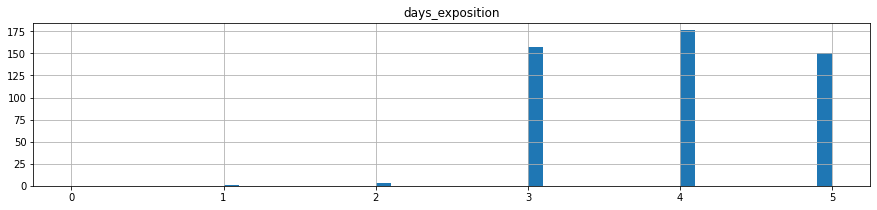

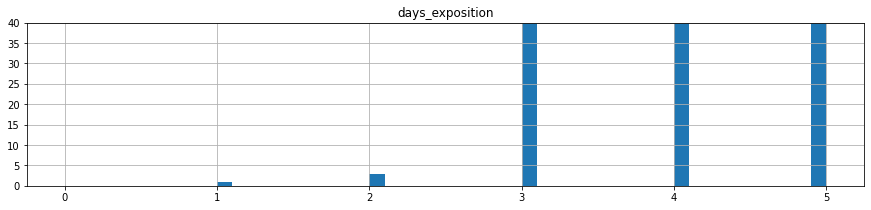

In [ ]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

In [ ]:
data['total_area'].value_counts()

45.00    413
42.00    379
44.00    344
31.00    342
60.00    340
        ... 
32.42      1
58.34      1
25.15      1
29.61      1
55.06      1
Name: total_area, Length: 2075, dtype: int64

In [ ]:
data.query ('days_exposition > 550')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2,10,5196000,56.00,2015-08-20,2,NaN,5,34.300000,4,False,...,8.3000,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
17,6,4180000,36.00,2016-09-09,1,NaN,17,16.500000,7,False,...,11.0000,1,санкт-петербург,33564.0,14616.0,0.0,NaN,1.0,859.0,571.0
23,11,2950000,32.00,2016-10-29,1,2.60,9,17.700000,9,False,...,6.1000,0,санкт-петербург,15414.0,14211.0,2.0,517.0,1.0,190.0,615.0
35,6,15500000,149.00,2017-06-26,5,NaN,5,104.000000,4,False,...,17.0000,0,санкт-петербург,23670.0,3502.0,0.0,NaN,1.0,779.0,644.0
42,13,22000000,161.80,2015-07-08,4,2.80,4,80.900000,2,False,...,17.6000,5,петергоф,35416.0,30605.0,2.0,47.0,1.0,907.0,987.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23155,1,2414306,40.50,2016-09-08,1,2.56,18,19.600000,10,False,...,7.0875,0,никольское,NaN,NaN,NaN,NaN,NaN,NaN,627.0
23164,5,9000000,110.00,2015-12-10,4,3.36,7,64.600000,5,False,...,15.8000,0,санкт-петербург,26313.0,5016.0,3.0,417.0,1.0,118.0,816.0
23172,5,3000000,30.80,2016-06-08,1,NaN,5,16.100000,3,False,...,6.3000,0,санкт-петербург,44614.0,14193.0,2.0,258.0,0.0,NaN,808.0
23175,8,3550000,39.50,2016-10-03,1,NaN,16,19.000000,13,False,...,8.5000,0,санкт-петербург,25740.0,14951.0,0.0,NaN,0.0,NaN,721.0


In [ ]:
data.drop(index=data.query('days_exposition > 550').index,inplace=True)

Теперь с кухней

In [ ]:
data.query ('kitchen_area > 25')
data['kitchen_area'].describe()

count    21922.000000
mean        10.225618
std          5.075734
min          2.000000
25%          7.000000
50%          9.000000
75%         11.725000
max         50.000000
Name: kitchen_area, dtype: float64

In [ ]:
data.drop(index=data.query('kitchen_area > 25').index,inplace=True)

In [ ]:
# check

(
        data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
              'floor', 'floors_total']]
        .apply (['count', 'min', 'max'])
        .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,458.00","21,458.00","13,009.00","18,477.00","21,458.00","21,458.00","21,458.00","21,458.00","21,378.00"
min,0.00,12.00,2.50,1.00,"430,000.00",10.00,2.00,1.00,2.00
max,7.00,413.50,4.00,550.00,"95,000,000.00",187.00,25.00,27.00,29.00


In [ ]:
data.rooms.value_counts().to_frame()

,rooms
1,7556
2,7290
3,5160
4,948
5,227
0,186
6,61
7,30


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21458 entries, 0 to 23198
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21458 non-null  int64         
 1   last_price            21458 non-null  int64         
 2   total_area            21458 non-null  float64       
 3   first_day_exposition  21458 non-null  datetime64[ns]
 4   rooms                 21458 non-null  int64         
 5   ceiling_height        13009 non-null  float64       
 6   floors_total          21378 non-null  Int8          
 7   living_area           21458 non-null  float64       
 8   floor                 21458 non-null  int64         
 9   is_apartment          21458 non-null  bool          
 10  studio                21458 non-null  bool          
 11  open_plan             21458 non-null  bool          
 12  kitchen_area          21458 non-null  float64       
 13  balcony         

Итак,
- дописал код для ceiling_height для перевода в дробные значения от 25 до 36.

- добавил и удалил данные по условиям:

rooms > 7
total_area > 500
days_exposition > 365*3
last_price > 100.000.000
living_area > 200
floors_total > 30
Удалил Null для

locality_name
floors_total

### Посчитайте и добавьте в таблицу новые столбцы

1. цена одного квадратного метра;
2. день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
3. месяц публикации объявления;
4. год публикации объявления;
5. тип этажа квартиры (значения — «‎первый», «последний», «другой»);
6. расстояние до центра города в километрах (переведите из м в км и округлите до целых значений)

**Создадим столбец с ценой одного кв. метра. Для удобства сразу преобразовываем в тип int.**

In [ ]:
data['price_per_square_meter'] = data['last_price'] / data['total_area']
data['price_per_square_meter'] = data['price_per_square_meter'].astype('int')

**Создаю столбец день недели.**

In [ ]:
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday

**Создаю столбец месяца.**

In [ ]:
data['month_exposition'] = data['first_day_exposition'].dt.month

**Создаю столбец года.**

In [ ]:
data['year_exposition'] = data['first_day_exposition'].dt.year

Для создания столбца Тип этажа создаю функцию категоризации по этажам

In [ ]:
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'

**Категоризирую этажи** и ввожу дополнительно столбец с цифровым обозначением категории этажа

In [ ]:
data['floor_category'] = data.apply(
    lambda x: 'первый' if (x.floor == 1)
    else ('последний' if (x.floor == x.floors_total) & isinstance(x.floors_total,int)
    else 'другой'), axis=1
)

data['floor_category_digit'] = data.apply(
    lambda x: 1 if (x.floor == 1)
    else (3 if (x.floor == x.floors_total) & isinstance(x.floors_total,int)
    else 2), axis=1
)

**Создаю столбец расстояния до центра в км. Округляю.**

In [ ]:
data['distance_to_centre'] = round(data['city_centers_nearest'] / 1000)

Выводим для проверки несколько строк дата-файла.

In [ ]:
data.head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,floor_category_digit,distance_to_centre
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.000000,8,False,...,2.0,755.0,NaN,120370,3,3,2019,другой,2,16.0
1,7,3350000,40.40,2018-12-04,1,NaN,11,18.600000,1,False,...,0.0,NaN,81.0,82920,1,12,2018,первый,1,19.0
5,10,2890000,30.40,2018-09-10,1,NaN,12,14.400000,5,False,...,NaN,NaN,55.0,95065,0,9,2018,другой,2,NaN
6,6,3700000,37.30,2017-11-02,1,NaN,26,10.600000,6,False,...,0.0,NaN,155.0,99195,3,11,2017,другой,2,19.0
7,5,7915000,71.60,2019-04-18,2,NaN,24,41.307692,22,False,...,0.0,NaN,NaN,110544,3,4,2019,другой,2,12.0
8,20,2900000,33.16,2018-05-23,1,NaN,27,15.430000,26,False,...,NaN,NaN,189.0,87454,2,5,2018,другой,2,NaN
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.600000,7,False,...,0.0,NaN,289.0,88524,6,2,2017,другой,2,15.0
10,5,5050000,39.60,2017-11-16,1,2.67,12,20.300000,3,False,...,2.0,553.0,137.0,127525,3,11,2017,другой,2,14.0
11,9,3300000,44.00,2018-08-27,2,NaN,5,31.000000,4,False,...,0.0,NaN,7.0,75000,0,8,2018,другой,2,52.0
12,10,3890000,54.00,2016-06-30,2,NaN,5,30.000000,5,False,...,NaN,NaN,90.0,72037,3,6,2016,последний,3,NaN


Предобработка данных завершена. Приступаю к исследовательскому анализу!

### Проведите исследовательский анализ данных

1. общая площадь;
2. жилая площадь;
3. площадь кухни;
4. цена объекта;
5. количество комнат;
6. высота потолков;
7. этаж квартиры;
8. тип этажа квартиры («первый», «последний», «другой»);
9. общее количество этажей в доме;
10. расстояние до центра города в метрах;
11. расстояние до ближайшего аэропорта;
12. расстояние до ближайшего парка;
13. день и месяц публикации объявления.

Движемся по пунктам. **Изучим общую площадь.**

count    21458.000000
mean        56.916996
std         26.103628
min         12.000000
25%         39.700000
50%         50.800000
75%         67.000000
max        413.500000
Name: total_area, dtype: float64

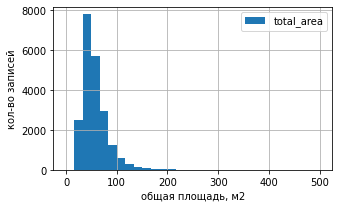

In [ ]:
(
data.plot(y = 'total_area', kind = 'hist', bins = 30, grid=True, figsize = (5,3), range = (0,500))
    .set( ylabel = 'кол-во записей', xlabel = 'общая площадь, м2')
)
data['total_area'].describe()

Наблюдаем очень малое количество квартир с общей площадью более 100 кв.м. Если построить "ящик с усами" явно будет немного значений которые покажутся выбросами, но это просто элитная недвижимость

Распределение данных нормальное, есть выбросы но они не сильно влияют на данные,
по гистограмме кроме распределения нечего больше указать, с помошью describe получил общее представление

**Изучим жилую площадь**

count    21458.000000
mean        32.838001
std         17.304342
min         10.000000
25%         18.800000
50%         30.000000
75%         41.100000
max        187.000000
Name: living_area, dtype: float64

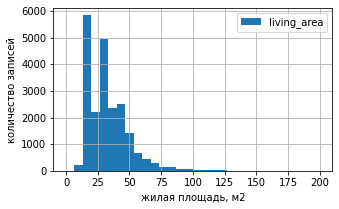

In [ ]:
(
data.plot(y = 'living_area', kind = 'hist', bins = 30, grid=True, figsize = (5,3), range = (0,200))
     .set( ylabel = 'количество записей', xlabel = 'жилая площадь, м2')
)
data['living_area'].describe()



Наблюдаем два пика - на 18 кв.м. и на 30 кв.м. Нужно проверить, почему у нас именно два пика и почему есть явный провал около 24 кв.м.

**Изучим площадь кухни**

count    21458.000000
mean         9.732467
std          3.738121
min          2.000000
25%          7.000000
50%          9.000000
75%         11.400000
max         25.000000
Name: kitchen_area, dtype: float64

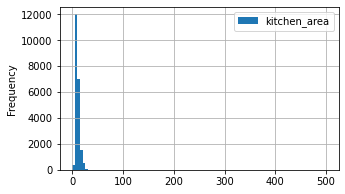

In [ ]:
data.plot(y = 'kitchen_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,500))
data['kitchen_area'].describe()

Площадь кухни выглядит хорошо.

**Изучим цену объекта**

count    2.145800e+04
mean     5.708676e+06
std      4.851984e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.500000e+06
75%      6.493268e+06
max      9.500000e+07
Name: last_price, dtype: float64

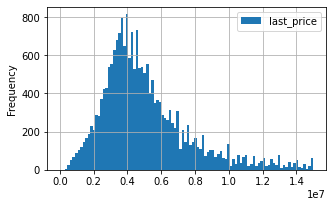

In [ ]:
data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, range = (0,15000000), figsize = (5,3))
data['last_price'].describe()

Цена объекта выглядит хорошо. Немного "шумный" график. Очень длинный "хвост" вправо - это похоже элитная недвижимость.

**Изучим количество комнат**

count    21458.000000
mean         2.009460
std          0.989743
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

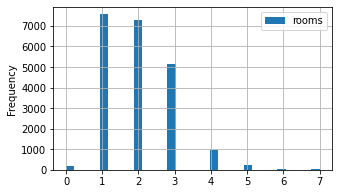

In [ ]:
data.plot(y = 'rooms', kind = 'hist', bins = 30, grid=True, figsize = (5,3))
data['rooms'].describe()

##### Больше всего одно- двух- и трёх-комнатных квартир, но встречаются и редкие исключения.

**Изучим высоту потолков**

count    13009.000000
mean         2.708641
std          0.244723
min          2.500000
25%          2.500000
50%          2.650000
75%          2.800000
max          4.000000
Name: ceiling_height, dtype: float64

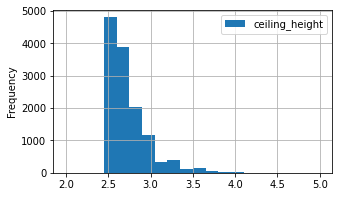

In [ ]:
data.plot(y = 'ceiling_height', kind = 'hist', range = (2,5), bins = 20, grid=True, figsize = (5,3))
data['ceiling_height'].describe()

Здесь два пика 2.5м и 3м, что логично.

**Изучим этаж квартиры**

count    21458.000000
mean         5.906049
std          4.874902
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64

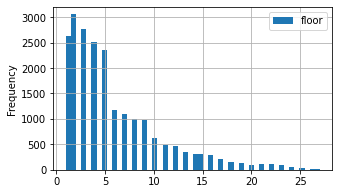

In [ ]:
data.plot(y = 'floor', kind = 'hist', bins = 50,  grid=True, figsize = (5,3))
data['floor'].describe()

Больше всего квартир с 1 по 5 этаж. Логино.

**Изучим общее кол-во этажей в доме**

count    21378.000000
mean        10.735289
std          6.551672
min          2.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64

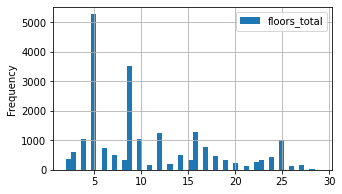

In [ ]:
data.plot(y = 'floors_total', kind = 'hist', bins = 50,  grid=True, figsize = (5,3))
data['floors_total'].describe()

Видим явные пики: 5-этажная застройка, 9-этажная застройка, и небольшие пики более высоких новостроек.

**Изучим расстояние до центра**

count    16337.000000
mean     14471.445675
std       8499.064103
min        181.000000
25%       9816.000000
50%      13271.000000
75%      16446.000000
max      65952.000000
Name: city_centers_nearest, dtype: float64

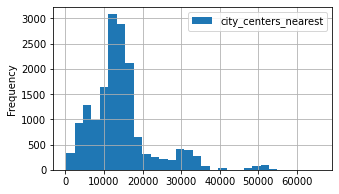

In [ ]:
data.plot(y = 'city_centers_nearest', kind = 'hist', bins = 30,  grid=True, figsize = (5,3))
data['city_centers_nearest'].describe()

Здесь наблюдаем два пика, один маленький, 5км и другой побльшой от 10 км. до 15 км. Так же есть совсем небольшие всплески на 30 км. и 50 км.

**Изучим расстояние до ближайшего аэропорта**

count    16318.000000
mean     28863.655656
std      12790.323900
min       6450.000000
25%      18396.000000
50%      26925.500000
75%      37434.000000
max      84853.000000
Name: airports_nearest, dtype: float64

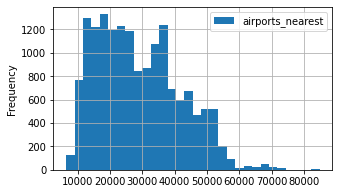

In [ ]:
data.plot(y = 'airports_nearest', kind = 'hist', bins = 30,  grid=True, figsize = (5,3))
data['airports_nearest'].describe()

Довольно равномерное распределение. Вполне нормально.

**Изучим расстояние до ближайшего парка**

count    7098.000000
mean      489.862637
std       335.120864
min         1.000000
25%       288.000000
50%       456.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

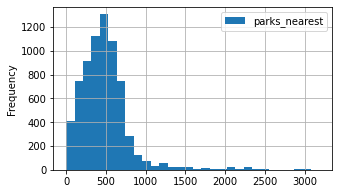

In [ ]:
data.plot(y = 'parks_nearest', kind = 'hist', bins = 30,  grid=True, figsize = (5,3))
data['parks_nearest'].describe()

Судя по графику больше всего квартир с парками на расстоянии до 750м.

**Изучим день публикации**

count    21458.000000
mean         2.575217
std          1.790296
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: weekday_exposition, dtype: float64

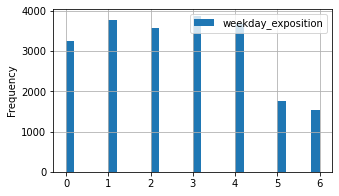

In [ ]:
data.plot(y = 'weekday_exposition', kind = 'hist', bins = 30,  grid=True, figsize = (5,3))
data['weekday_exposition'].describe()

**Изучим месяц публикации**

count    21458.00000
mean         6.40563
std          3.48557
min          1.00000
25%          3.00000
50%          6.00000
75%         10.00000
max         12.00000
Name: month_exposition, dtype: float64

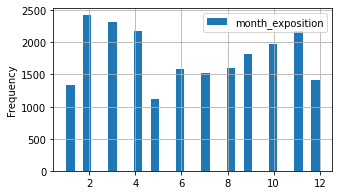

In [ ]:
data.plot(y = 'month_exposition', kind = 'hist', bins = 30,  grid=True, figsize = (5,3))
data['month_exposition'].describe()

count    21458.000000
mean      2017.486112
std          0.936447
min       2014.000000
25%       2017.000000
50%       2018.000000
75%       2018.000000
max       2019.000000
Name: year_exposition, dtype: float64

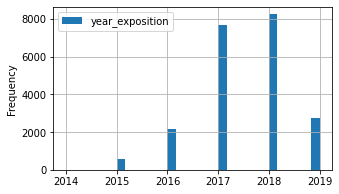

In [ ]:
data.plot(y = 'year_exposition', kind = 'hist', bins = 30,  grid=True, figsize = (5,3))
data['year_exposition'].describe()

Видим провал в публикации объявлений в субботу и воскресенье, что логично. Так же видим что с февраля по апрель наблюдалосась повышенная активность. Так же был плавный рост активности с июля по ноябрь. Провалы в декабре, январе и мае.

**Изучим тип этажа квартиры**

count      21458
unique         3
top       другой
freq       15869
Name: floor_category, dtype: object

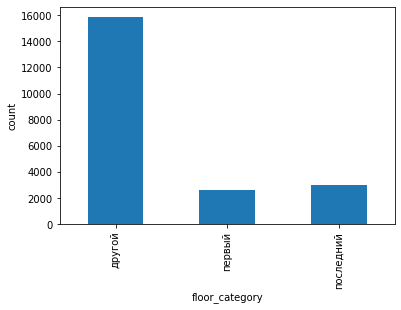

In [ ]:
data.groupby(by='floor_category')['floor_category'].count().plot(kind='bar', ylabel = 'count');
data ['floor_category'].describe()

Больше всего квартир на "другом" этаже и это логично. Первых и последних этажей одинакого мало.

Построим график значений для столбца с высотой потолков

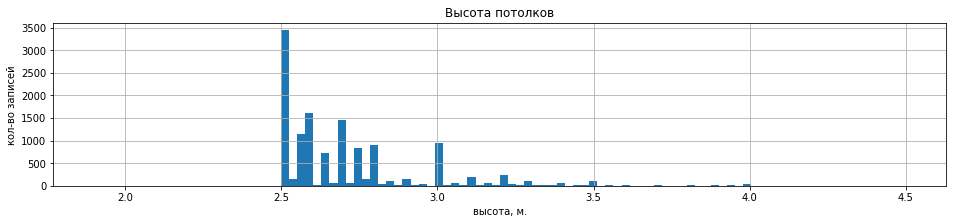

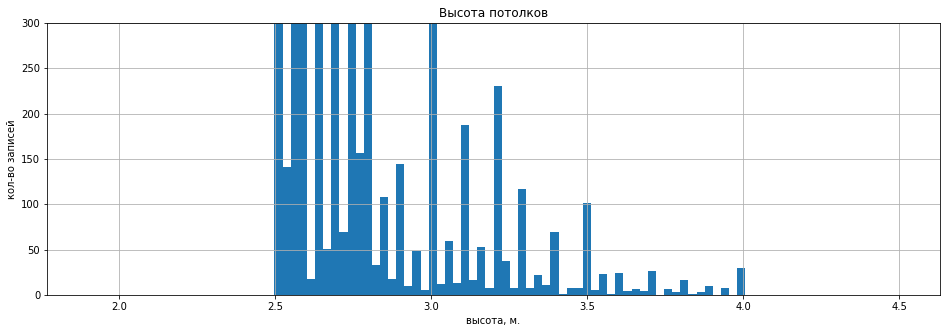

In [ ]:
(
    data['ceiling_height']
        .sort_values()
        .plot(y='ceiling_height', kind='hist',
              bins=100, range=(1.9,4.5), grid=True, title='Высота потолков', figsize=(16,3))
        .set( ylabel = 'кол-во записей', xlabel = 'высота, м.')
)
plt.show()
(
    data['ceiling_height']
        .sort_values()
        .plot(y='ceiling_height', kind='hist',
              bins=100, range=(1.9,4.5), grid=True, title='Высота потолков', figsize=(16,5))
        .set(ylim = (0, 300), ylabel = 'кол-во записей', xlabel = 'высота, м.')

)
plt.show()

Вывод не добавил, да. Интересно стало, в какой диапазон укладывается высота. Поподробнее. Эх...родительская хрущёвка уже не котируется. Всё в диапазоне от 2,5 до 4 метров.

**Изучение days_exposition -/ как быстро продавались квартиры**

Среднее время продажи квартиры в днях: 131
Медианное время продажи квартиры в днях: 85

[Выбросы] Количество объявлений, которые сняты через:
До 45 дней: 4971
От 45 до 60 дней: 2488
От 60 до 90 дней: 2047
90 дней и более: 8971


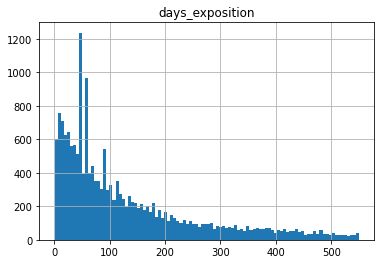

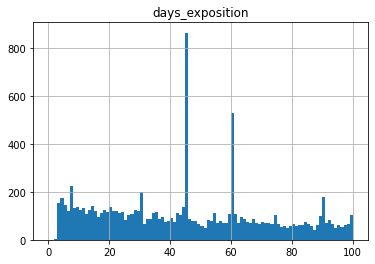

In [ ]:
data ['days_exposition'].describe()
data.hist('days_exposition', bins=100);
data.hist('days_exposition', bins=100, range = (0,100));
print('Среднее время продажи квартиры в днях:',int(data['days_exposition'].mean()))
print('Медианное время продажи квартиры в днях:',int(data['days_exposition'].median()))

print('\n[Выбросы] Количество объявлений, которые сняты через:')
print('До 45 дней:',data[data['days_exposition']<=45]['days_exposition'].count())
print('От 45 до 60 дней:',data[data['days_exposition']<=60 ]['days_exposition']
      .count() - data[data['days_exposition']<=45 ]['days_exposition'].count())
print('От 60 до 90 дней:',data[data['days_exposition']<=90 ]['days_exposition']
      .count() - data[data['days_exposition']<=60 ]['days_exposition'].count())
print('90 дней и более:',data[data['days_exposition']>=90]['days_exposition'].count())


Можно сказать, что среднее время продажи квартиры составляет 131 день или целые полгода. Но если взять медиану - то это уже 85 дня, в два раза меньше почти. Почему так? Потому что у нас есть "длинный хвост" квартир, которые продавались очень долго, буквально годами.
Я бы предложил считать быстрыми продажи до 85 дней, а необычно долгими - свыше 131 дня. Выбросы похожи на платные объявления с истекшим сроком размещения или работу ситемы удаления неактивных объявлений.

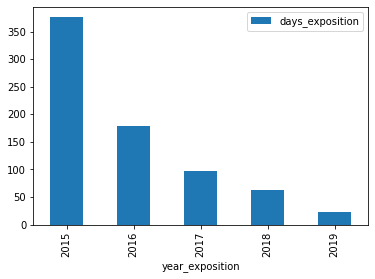

In [ ]:
data.pivot_table(index='year_exposition',values='days_exposition', aggfunc = 'median').plot(y='days_exposition', kind='bar');

**Факторы оторые больше всего влияют на общую (полную) стоимость объекта**
- Изучить, зависит ли цена от:
1. Общей площади;
2. Жилой площади;
3. Площади кухни;
4. Количества комнат;
5. Этажа, на котором расположена квартира (первый, последний, другой);
6. Даты размещения (день недели, месяц, год).
Постройть графики, которые покажут зависимость цены от указанных выше параметров. Для подготовки данных перед визуализацией можно использовать сводные таблицы.

In [ ]:
list_needed = ['total_area',
                  'living_area',
                  'kitchen_area',
                  'rooms',
                  'floor_category_digit',
                  ]

for item in list_needed:
    correlation = data['last_price'].corr(data[item])
    print(f'Корреляция между last_price и {item} составляет: {correlation:0.2%}')

Корреляция между last_price и total_area составляет: 74.28%
Корреляция между last_price и living_area составляет: 66.28%
Корреляция между last_price и kitchen_area составляет: 51.90%
Корреляция между last_price и rooms составляет: 45.57%
Корреляция между last_price и floor_category_digit составляет: 4.97%


Уберём данные о сверх-дорогих квартир потому что они очень сильно влияют на корреляции...

<AxesSubplot:xlabel='last_price', ylabel='kitchen_area'>

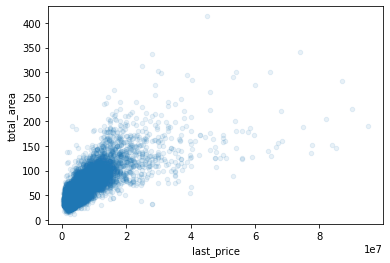

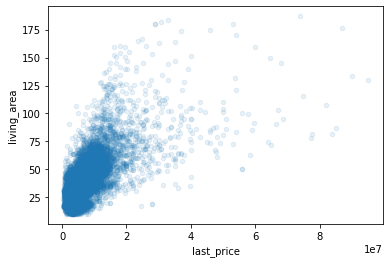

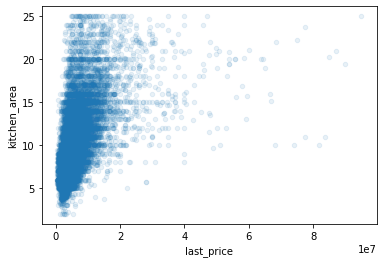

In [ ]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.1)
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.1)
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.1)

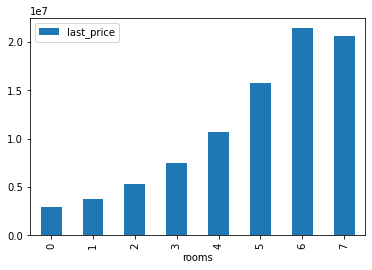

In [ ]:
data.pivot_table(index='rooms',values='last_price').plot(y='last_price', kind='bar');

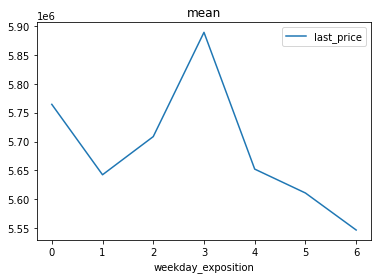

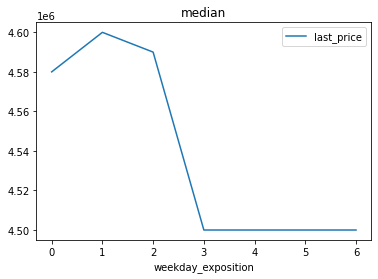

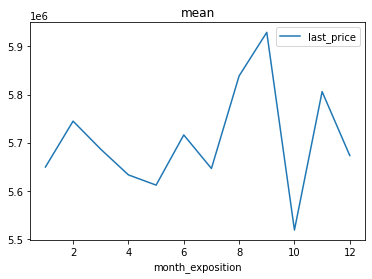

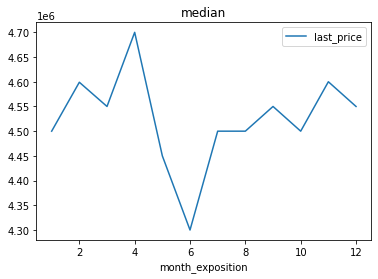

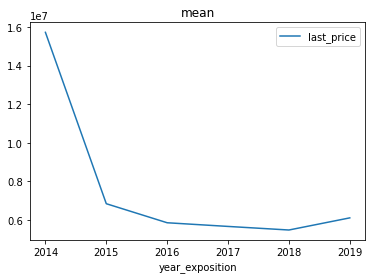

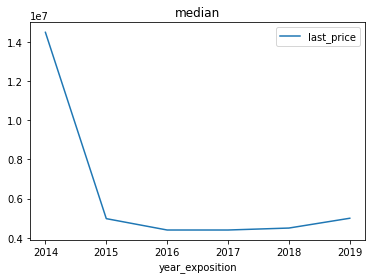

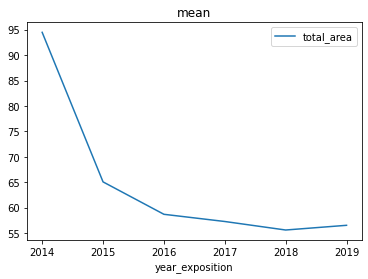

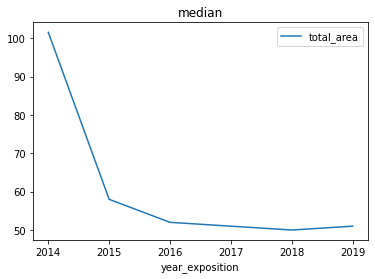

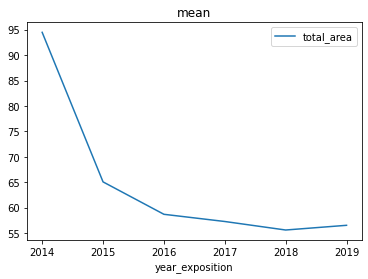

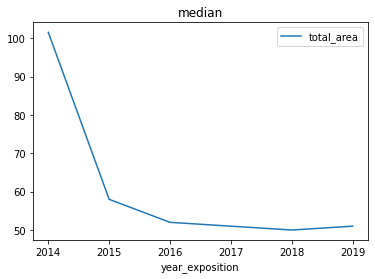

In [ ]:
data.pivot_table(index='weekday_exposition',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='weekday_exposition',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

data.pivot_table(index='month_exposition',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='month_exposition',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

data.pivot_table(index='year_exposition',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='year_exposition',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

data.pivot_table(index='year_exposition',values='total_area',aggfunc='mean').plot(y='total_area', kind='line', title='mean');
data.pivot_table(index='year_exposition',values='total_area',aggfunc='median').plot(y='total_area', kind='line', title='median');

data.pivot_table(index='year_exposition',values='total_area',aggfunc='mean').plot(y='total_area', kind='line', title='mean');
data.pivot_table(index='year_exposition',values='total_area',aggfunc='median').plot(y='total_area', kind='line', title='median');

Цена по убыванию зависит от:

- общей площади;
- жилой площади;
- площади кухни;
- количества комнат.

Цена практически на зависит от:

- этажа, на котором расположена квартира;
- даты размещения.

Изменение цены и площади квартир по годам очень хорошо отражает политическую ситуацию:
 - пик к 2014
 - спад в связи с кризисом
 - постепенный рост с 2017

А вот количество объявлений по годам (график построен ранее) ведёт себя несколько по-другому. Минимум в кризисном 2014 и затем постоянный рост до 2018. Предпандемийный 2019 снова спад... Не могу объяснить. Возможно, всё дело в нашей выборке.

Доля квартир дороже 10 млн для средних этажей составляет 9-10%, с годами сохраняется.


**Год 2015**

In [ ]:
data[data['floor_category']=='другой'].query('last_price > 10000000 & year_exposition == 2015').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category_digit,distance_to_centre
count,59.000000,5.900000e+01,59.000000,59.000000,31.000000,59.000000,59.000000,59.000000,59.000000,59.000000,...,41.000000,59.000000,45.000000,36.000000,59.000000,59.000000,59.000000,59.0,59.0,59.000000
mean,7.847458,1.930718e+07,121.276271,3.338983,3.133871,8.813559,70.708266,4.254237,16.266144,0.423729,...,460.926829,1.508475,385.022222,391.722222,161732.254237,2.457627,7.627119,2015.0,2.0,8.050847
std,6.299462,1.320466e+07,45.967891,1.027387,0.346753,5.114127,30.736505,2.495466,3.858120,0.875005,...,236.130937,1.119927,253.718302,107.395294,93682.493942,1.304132,3.522824,0.0,0.0,10.404614
min,0.000000,1.001800e+07,67.700000,2.000000,2.600000,3.000000,30.200000,2.000000,9.000000,0.000000,...,51.000000,0.000000,22.000000,215.000000,75177.000000,0.000000,1.000000,2015.0,2.0,0.000000
25%,3.000000,1.165000e+07,92.500000,3.000000,3.000000,5.000000,50.000000,2.000000,13.550000,0.000000,...,265.000000,1.000000,206.000000,307.250000,112372.500000,2.000000,5.500000,2015.0,2.0,3.500000
50%,7.000000,1.490000e+07,108.000000,3.000000,3.000000,7.000000,63.100000,4.000000,16.000000,0.000000,...,471.000000,1.000000,356.000000,377.500000,131355.000000,3.000000,8.000000,2015.0,2.0,5.000000
75%,12.000000,1.916750e+07,146.600000,4.000000,3.300000,11.000000,88.000000,5.000000,19.525000,1.000000,...,645.000000,2.500000,511.000000,506.000000,178162.500000,3.000000,10.500000,2015.0,2.0,8.000000
max,20.000000,7.390000e+07,342.000000,5.000000,4.000000,23.000000,187.000000,12.000000,24.150000,4.000000,...,980.000000,3.000000,1093.000000,547.000000,590694.000000,6.000000,12.000000,2015.0,2.0,51.000000


In [ ]:
data[data['floor_category']=='другой'].query('year_exposition == 2015').count()

total_images              390
last_price                390
total_area                390
first_day_exposition      390
rooms                     390
ceiling_height            168
floors_total              388
living_area               390
floor                     390
is_apartment              390
studio                    390
open_plan                 390
kitchen_area              390
balcony                   390
locality_name             377
airports_nearest          327
city_centers_nearest      327
parks_around3000          327
parks_nearest             151
ponds_around3000          327
ponds_nearest             180
days_exposition           350
price_per_square_meter    390
weekday_exposition        390
month_exposition          390
year_exposition           390
floor_category            390
floor_category_digit      390
distance_to_centre        327
dtype: int64

За 2015 год эта доля составляет 15%

**Год 2016**

In [ ]:
data[data['floor_category']=='другой'].query('last_price > 10000000 & year_exposition == 2016').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category_digit,distance_to_centre
count,171.000000,1.710000e+02,171.000000,171.000000,96.000000,169.000000,171.000000,171.000000,171.00000,171.000000,...,113.000000,171.000000,115.000000,157.000000,171.000000,171.000000,171.000000,171.0,171.0,171.000000
mean,9.754386,1.823644e+07,115.482281,3.292398,3.075729,10.698225,67.547108,5.976608,15.86693,0.573099,...,496.796460,1.216374,475.713043,241.025478,159575.684211,2.502924,5.573099,2016.0,2.0,7.818713
std,6.547422,1.182863e+07,39.330654,1.066551,0.280525,5.698585,28.016219,4.304516,3.82062,1.022788,...,374.824868,1.059950,260.353193,146.522684,71758.170769,1.602844,2.745945,0.0,0.0,5.056958
min,0.000000,1.015000e+07,54.500000,1.000000,2.500000,3.000000,19.700000,2.000000,6.00000,0.000000,...,39.000000,0.000000,24.000000,7.000000,70343.000000,0.000000,1.000000,2016.0,2.0,1.000000
25%,4.000000,1.190000e+07,87.450000,3.000000,2.847500,6.000000,48.150000,3.000000,13.10000,0.000000,...,257.000000,0.000000,271.000000,101.000000,120612.000000,1.000000,4.000000,2016.0,2.0,5.000000
50%,10.000000,1.375000e+07,108.600000,3.000000,3.090000,8.000000,62.600000,5.000000,15.50000,0.000000,...,456.000000,1.000000,473.000000,214.000000,138392.000000,3.000000,5.000000,2016.0,2.0,7.000000
75%,16.000000,1.908534e+07,133.300000,4.000000,3.200000,16.000000,80.810000,7.000000,18.00000,1.000000,...,613.000000,2.000000,608.500000,357.000000,172266.500000,3.000000,6.000000,2016.0,2.0,9.500000
max,24.000000,9.000000e+07,284.000000,7.000000,4.000000,25.000000,154.000000,24.000000,25.00000,5.000000,...,2409.000000,3.000000,1180.000000,531.000000,451766.000000,6.000000,12.000000,2016.0,2.0,34.000000


In [ ]:
data[data['floor_category']=='другой'].query('year_exposition == 2016').count()

total_images              1593
last_price                1593
total_area                1593
first_day_exposition      1593
rooms                     1593
ceiling_height             708
floors_total              1574
living_area               1593
floor                     1593
is_apartment              1593
studio                    1593
open_plan                 1593
kitchen_area              1593
balcony                   1593
locality_name             1580
airports_nearest          1294
city_centers_nearest      1297
parks_around3000          1297
parks_nearest              558
ponds_around3000          1297
ponds_nearest              643
days_exposition           1557
price_per_square_meter    1593
weekday_exposition        1593
month_exposition          1593
year_exposition           1593
floor_category            1593
floor_category_digit      1593
distance_to_centre        1297
dtype: int64

**За 2016 год эта доля составляет 10.7%**

**Год 2017**

In [ ]:
data[data['floor_category']=='другой'].query('last_price > 10000000 & year_exposition == 2017').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category_digit,distance_to_centre
count,543.000000,5.430000e+02,543.000000,543.000000,337.000000,537.000000,543.000000,543.000000,543.000000,543.000000,...,334.000000,538.000000,348.000000,486.000000,543.000000,543.000000,543.000000,543.0,543.0,538.000000
mean,11.642726,1.692303e+07,109.381344,3.152855,3.029169,11.605214,63.247389,6.333333,15.555228,0.865562,...,561.251497,1.150558,483.511494,182.779835,156608.600368,2.585635,7.841621,2017.0,2.0,8.301115
std,6.625831,1.031401e+07,35.348056,1.091998,0.314120,6.855152,24.633365,4.851041,4.119056,1.327530,...,494.344875,1.095789,279.271185,145.962906,70186.364968,1.812100,3.141902,0.0,0.0,5.808428
min,0.000000,1.004850e+07,45.700000,0.000000,2.500000,3.000000,20.000000,2.000000,6.300000,0.000000,...,9.000000,0.000000,16.000000,3.000000,64285.000000,0.000000,1.000000,2017.0,2.0,0.000000
25%,6.000000,1.160450e+07,85.200000,3.000000,2.800000,6.000000,47.400000,3.000000,12.500000,0.000000,...,288.500000,0.000000,246.000000,85.000000,114707.000000,1.000000,6.000000,2017.0,2.0,5.000000
50%,11.000000,1.350000e+07,102.000000,3.000000,3.000000,9.000000,58.100000,5.000000,15.000000,0.000000,...,454.500000,1.000000,444.000000,134.500000,138858.000000,3.000000,9.000000,2017.0,2.0,7.000000
75%,17.000000,1.750000e+07,124.350000,4.000000,3.200000,17.000000,74.130000,8.000000,18.300000,2.000000,...,633.000000,2.000000,722.000000,270.750000,175079.500000,4.000000,10.500000,2017.0,2.0,12.000000
max,50.000000,8.382000e+07,336.000000,7.000000,4.000000,27.000000,180.000000,24.000000,25.000000,5.000000,...,2905.000000,3.000000,1293.000000,549.000000,721518.000000,6.000000,12.000000,2017.0,2.0,51.000000


In [ ]:
data[data['floor_category']=='другой'].query('year_exposition == 2017').count()

total_images              5713
last_price                5713
total_area                5713
first_day_exposition      5713
rooms                     5713
ceiling_height            2999
floors_total              5691
living_area               5713
floor                     5713
is_apartment              5713
studio                    5713
open_plan                 5713
kitchen_area              5713
balcony                   5713
locality_name             5710
airports_nearest          4597
city_centers_nearest      4605
parks_around3000          4605
parks_nearest             1944
ponds_around3000          4605
ponds_nearest             2272
days_exposition           5565
price_per_square_meter    5713
weekday_exposition        5713
month_exposition          5713
year_exposition           5713
floor_category            5713
floor_category_digit      5713
distance_to_centre        4605
dtype: int64

За 2017 год эта доля составляет 9,5%

In [ ]:
data[data['floor_category']=='другой'].query('last_price > 10000000 & year_exposition == 2018').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category_digit,distance_to_centre
count,542.000000,5.420000e+02,542.000000,542.000000,390.000000,540.000000,542.000000,542.000000,542.000000,542.000000,...,338.000000,535.000000,333.00000,410.000000,542.000000,542.000000,542.000000,542.0,542.0,535.000000
mean,12.232472,1.537946e+07,103.993727,3.101476,2.940590,12.135185,60.665854,6.677122,15.132877,0.671587,...,534.174556,1.183178,474.69970,126.180488,154329.214022,2.573801,6.378229,2018.0,2.0,9.005607
std,6.431023,6.201559e+06,37.219173,1.119000,0.272598,6.692439,24.841497,5.010617,3.938074,1.257541,...,411.782406,1.164430,278.40026,98.566605,57753.736183,1.803953,3.525839,0.0,0.0,5.599121
min,0.000000,1.001280e+07,38.120000,1.000000,2.500000,3.000000,15.000000,2.000000,5.300000,0.000000,...,13.000000,0.000000,13.00000,3.000000,57200.000000,0.000000,1.000000,2018.0,2.0,0.000000
25%,7.000000,1.130000e+07,80.025000,2.000000,2.750000,6.000000,44.100000,3.000000,12.100000,0.000000,...,288.250000,0.000000,241.00000,59.250000,122899.000000,1.000000,3.000000,2018.0,2.0,5.000000
50%,13.000000,1.318950e+07,96.000000,3.000000,2.900000,10.000000,55.000000,5.000000,14.800000,0.000000,...,481.000000,1.000000,458.00000,93.000000,142857.000000,3.000000,7.000000,2018.0,2.0,8.000000
75%,18.000000,1.662500e+07,118.000000,4.000000,3.050000,17.000000,71.094231,9.000000,17.775000,1.000000,...,644.750000,2.000000,665.00000,168.000000,169882.750000,4.000000,9.000000,2018.0,2.0,12.000000
max,37.000000,4.800000e+07,413.500000,7.000000,4.000000,28.000000,184.000000,25.000000,25.000000,5.000000,...,2847.000000,3.000000,1251.00000,445.000000,640422.000000,6.000000,12.000000,2018.0,2.0,36.000000


In [ ]:
data[data['floor_category']=='другой'].query('year_exposition == 2018').count()

total_images              6096
last_price                6096
total_area                6096
first_day_exposition      6096
rooms                     6096
ceiling_height            4080
floors_total              6070
living_area               6096
floor                     6096
is_apartment              6096
studio                    6096
open_plan                 6096
kitchen_area              6096
balcony                   6096
locality_name             6091
airports_nearest          4623
city_centers_nearest      4629
parks_around3000          4629
parks_nearest             1860
ponds_around3000          4629
ponds_nearest             2229
days_exposition           5497
price_per_square_meter    6096
weekday_exposition        6096
month_exposition          6096
year_exposition           6096
floor_category            6096
floor_category_digit      6096
distance_to_centre        4629
dtype: int64

За 2018 год эта доля составляет 9%

In [ ]:
data[data['floor_category']=='другой'].query('last_price > 10000000 & year_exposition == 2019').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category_digit,distance_to_centre
count,222.000000,2.220000e+02,222.000000,222.000000,182.000000,220.000000,222.000000,222.000000,222.000000,222.000000,...,135.000000,214.000000,125.000000,47.000000,222.000000,222.000000,222.000000,222.0,222.0,213.000000
mean,13.004505,1.666545e+07,104.484414,3.157658,2.987692,11.513636,62.072798,6.396396,15.253390,0.626126,...,463.844444,1.074766,473.000000,37.148936,166951.765766,2.337838,2.887387,2019.0,2.0,8.309859
std,6.517292,9.110331e+06,35.212047,1.124555,0.310576,6.789382,25.456582,4.918851,4.585068,1.172784,...,330.739602,1.131711,262.105156,26.860330,90699.750433,1.745922,1.117902,0.0,0.0,4.839670
min,0.000000,1.011750e+07,33.000000,1.000000,2.500000,3.000000,19.038462,2.000000,5.500000,0.000000,...,38.000000,0.000000,16.000000,4.000000,56849.000000,0.000000,1.000000,2019.0,2.0,0.000000
25%,8.000000,1.190000e+07,81.000000,3.000000,2.800000,5.000000,46.000000,3.000000,11.825000,0.000000,...,271.500000,0.000000,233.000000,14.000000,124166.000000,1.000000,2.000000,2019.0,2.0,4.000000
50%,14.000000,1.375260e+07,95.550000,3.000000,3.000000,10.000000,56.000000,5.000000,14.800000,0.000000,...,441.000000,1.000000,471.000000,30.000000,149510.000000,2.000000,3.000000,2019.0,2.0,7.000000
75%,20.000000,1.772500e+07,120.075000,4.000000,3.140000,16.000000,76.000000,9.000000,18.000000,1.000000,...,557.000000,2.000000,689.000000,54.500000,179444.250000,3.750000,4.000000,2019.0,2.0,12.000000
max,20.000000,9.500000e+07,263.800000,7.000000,4.000000,27.000000,164.300000,23.000000,25.000000,5.000000,...,2768.000000,3.000000,1251.000000,97.000000,848484.000000,6.000000,5.000000,2019.0,2.0,28.000000


In [ ]:
data[data['floor_category']=='другой'].query('year_exposition == 2019').count()

total_images              2065
last_price                2065
total_area                2065
first_day_exposition      2065
rooms                     2065
ceiling_height            1589
floors_total              2057
living_area               2065
floor                     2065
is_apartment              2065
studio                    2065
open_plan                 2065
kitchen_area              2065
balcony                   2065
locality_name             2065
airports_nearest          1627
city_centers_nearest      1626
parks_around3000          1627
parks_nearest              698
ponds_around3000          1627
ponds_nearest              764
days_exposition            815
price_per_square_meter    2065
weekday_exposition        2065
month_exposition          2065
year_exposition           2065
floor_category            2065
floor_category_digit      2065
distance_to_centre        1626
dtype: int64

За 2019 год эта доля составляет 10,8%

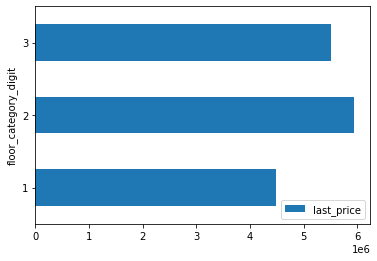

In [ ]:
data.pivot_table(index='floor_category_digit',values='last_price').plot(y='last_price', kind='barh');


**Cредняя цена одного квадратного метра в топ-10 населенных пунктах**

<AxesSubplot:ylabel='locality_name'>

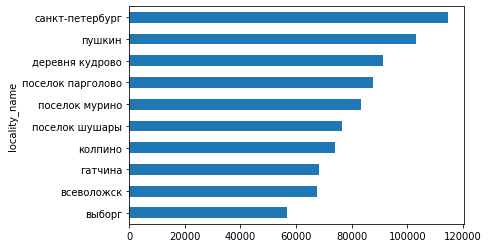

In [ ]:
top_10 = data.pivot_table(index='locality_name', values=['last_price','total_area'] ,aggfunc=['sum','count'])
top_10.columns=['last_price_sum','total_area_sum','last_price_count','total_area_count']
top_10.pop('total_area_count')
top_10.sort_values(by=['last_price_count'],ascending=False, inplace=True)
top_10 = top_10.iloc[:10]
top_10['price_per_sq_m'] = top_10['last_price_sum']/top_10['total_area_sum']
top_10.sort_values(by=['price_per_sq_m'],ascending=True, inplace=True)
top_10['price_per_sq_m'].plot(kind='barh')

In [ ]:
data['rooms'].value_counts()

1    7556
2    7290
3    5160
4     948
5     227
0     186
6      61
7      30
Name: rooms, dtype: int64

Ожидаемо самая дорогая недвижимость в Санкт-Петербурге.
В ТОП-10 входят ближайшие к Санкт-Петербургу города.

**Расстояние до центра города**

<AxesSubplot:xlabel='distance_to_centre'>

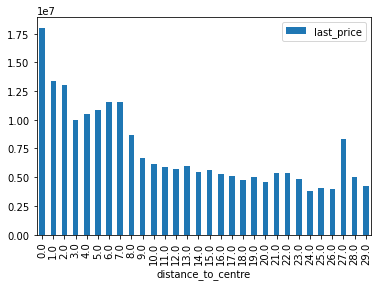

In [ ]:
(
    data[data['locality_name']=='санкт-петербург']
    .pivot_table(
        index='distance_to_centre',
        values='last_price',
        aggfunc='mean')
    .plot(kind='bar')
)

<AxesSubplot:xlabel='floor_category'>

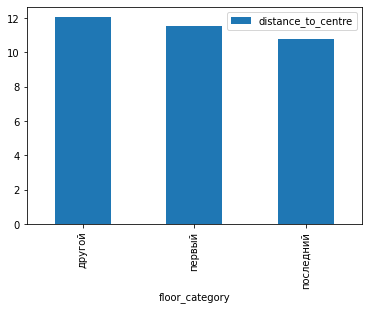

In [ ]:
(
    data[data['locality_name']=='санкт-петербург']
    .pivot_table(
        index='floor_category',
        values='distance_to_centre',
        aggfunc='mean')
    .plot(kind='bar')
)

<AxesSubplot:xlabel='floor_category'>

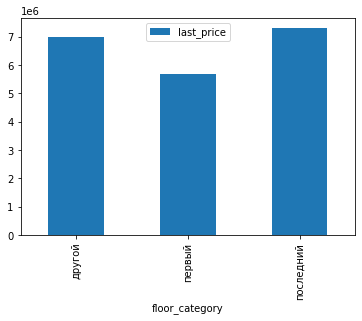

In [ ]:
(
    data[data['locality_name']=='санкт-петербург']
    .pivot_table(
        index='floor_category',
        values='last_price',
        aggfunc='mean')
    .plot(kind='bar')
)

In [ ]:
data[data['locality_name']=='санкт-петербург'].query('distance_to_centre == 27')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,floor_category_digit,distance_to_centre
726,13,14350000,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,0.0,NaN,128.0,193918,1,11,2017,другой,2,27.0
5832,6,2250000,32.0,2018-02-27,1,NaN,2,16.5,2,False,...,0.0,NaN,178.0,70312,1,2,2018,последний,3,27.0


С большим отрывом лидирует недвижимость до 1км.
Видим более низкие цены на недвижимость на расстоянии от 1 км. до 7 км. включительно.
Далее цена спадает на расстоянии от 8 км. до 27 км.
Видим пик на 27км, связанный с наличием очень больших квартир.
На 3 км преобладают дома 5-6 этажей

In [ ]:
data[data['floor_category']=='первый'].query('locality_name =="санкт-петербург" & distance_to_centre == 3 ').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category_digit,distance_to_centre
count,46.000000,4.600000e+01,46.000000,46.000000,31.000000,46.000000,46.000000,46.0,46.000000,46.0,...,35.000000,46.000000,39.000000,37.000000,46.000000,46.000000,46.000000,46.000000,46.0,46.0
mean,9.630435,7.392846e+06,65.402174,2.217391,3.109677,4.652174,39.192525,1.0,10.711413,0.0,...,446.771429,1.739130,397.666667,141.756757,111212.434783,2.000000,6.695652,2017.369565,1.0,3.0
std,5.186987,4.833915e+06,29.154230,1.209463,0.330076,0.993700,20.361526,0.0,3.976798,0.0,...,205.726987,1.143771,284.321198,141.984429,39527.717655,1.490712,3.372237,1.102698,0.0,0.0
min,0.000000,2.800000e+06,31.000000,1.000000,2.600000,2.000000,12.800000,1.0,6.300000,0.0,...,85.000000,0.000000,52.000000,3.000000,63524.000000,0.000000,1.000000,2015.000000,1.0,3.0
25%,6.250000,4.825000e+06,46.850000,1.000000,2.830000,4.000000,26.550000,1.0,8.000000,0.0,...,305.500000,1.000000,137.500000,36.000000,90944.000000,1.000000,3.250000,2017.000000,1.0,3.0
50%,9.000000,5.500000e+06,58.350000,2.000000,3.100000,5.000000,35.000000,1.0,9.400000,0.0,...,445.000000,1.500000,365.000000,85.000000,103638.000000,2.000000,7.500000,2017.000000,1.0,3.0
75%,13.750000,8.087500e+06,76.750000,3.000000,3.300000,5.000000,46.200000,1.0,12.000000,0.0,...,539.000000,3.000000,575.000000,220.000000,118202.500000,3.000000,9.750000,2018.000000,1.0,3.0
max,20.000000,2.520000e+07,162.000000,6.000000,3.800000,7.000000,101.000000,1.0,21.300000,0.0,...,985.000000,3.000000,1077.000000,497.000000,324675.000000,6.000000,11.000000,2019.000000,1.0,3.0


In [ ]:
data[data['floor_category']=='первый'].query('locality_name =="санкт-петербург" & distance_to_centre == 5 ').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category_digit,distance_to_centre
count,71.000000,7.100000e+01,71.000000,71.000000,45.000000,71.000000,71.000000,71.0,71.000000,71.000000,...,52.000000,71.000000,38.000000,58.000000,71.000000,71.000000,71.000000,71.000000,71.0,71.0
mean,8.605634,7.485788e+06,67.730704,2.661972,3.064889,5.323944,41.452958,1.0,10.299754,0.070423,...,419.769231,0.802817,591.368421,164.137931,112621.746479,2.605634,6.507042,2017.338028,1.0,5.0
std,5.426072,3.889783e+06,28.476883,1.351651,0.296492,1.696843,20.643038,0.0,3.981288,0.308172,...,216.559879,0.965397,303.886841,139.092983,31062.419792,1.792675,3.413725,0.999195,0.0,0.0
min,0.000000,2.740000e+06,20.000000,1.000000,2.500000,2.000000,14.000000,1.0,4.000000,0.000000,...,90.000000,0.000000,134.000000,4.000000,60879.000000,0.000000,1.000000,2015.000000,1.0,5.0
25%,5.000000,5.075000e+06,45.650000,2.000000,2.870000,5.000000,25.500000,1.0,7.250000,0.000000,...,236.000000,0.000000,314.500000,57.000000,90566.000000,1.000000,3.500000,2017.000000,1.0,5.0
50%,7.000000,6.500000e+06,64.000000,2.000000,3.000000,5.000000,36.400000,1.0,9.000000,0.000000,...,388.500000,1.000000,629.000000,113.000000,106557.000000,2.000000,6.000000,2017.000000,1.0,5.0
75%,12.500000,8.500000e+06,81.700000,3.000000,3.300000,6.000000,52.450000,1.0,13.000000,0.000000,...,615.750000,1.000000,830.750000,257.750000,126148.000000,4.000000,9.500000,2018.000000,1.0,5.0
max,20.000000,2.400000e+07,147.980000,7.000000,4.000000,12.000000,101.000000,1.0,22.300000,2.000000,...,906.000000,3.000000,1156.000000,504.000000,230263.000000,6.000000,12.000000,2019.000000,1.0,5.0


In [ ]:
data[data['floor_category']=='последний'].query('locality_name =="санкт-петербург" & distance_to_centre == 3 ').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category_digit,distance_to_centre
count,66.000000,6.600000e+01,66.000000,66.000000,41.000000,66.000000,66.000000,66.000000,66.000000,66.000000,...,48.000000,66.000000,55.000000,52.000000,66.000000,66.000000,66.000000,66.000000,66.0,66.0
mean,10.090909,1.092834e+07,89.540303,3.015152,3.131463,4.818182,56.457226,4.818182,12.169205,0.090909,...,377.916667,1.469697,511.927273,161.961538,118454.212121,2.848485,6.469697,2017.469697,3.0,3.0
std,5.565629,1.047861e+07,43.444542,1.341554,0.318642,1.094168,29.629976,1.094168,4.508542,0.289683,...,162.567542,1.098526,273.735737,137.609701,39562.741350,1.773674,3.402351,0.995678,0.0,0.0
min,0.000000,3.500000e+06,27.200000,1.000000,2.500000,3.000000,12.100000,3.000000,5.200000,0.000000,...,41.000000,0.000000,50.000000,5.000000,75782.000000,0.000000,1.000000,2015.000000,3.0,3.0
25%,6.250000,6.300000e+06,61.250000,2.000000,2.930000,4.000000,37.000000,4.000000,8.875000,0.000000,...,250.000000,1.000000,245.500000,67.750000,91942.250000,2.000000,4.000000,2017.000000,3.0,3.0
50%,10.000000,8.425000e+06,76.550000,3.000000,3.100000,5.000000,47.700000,5.000000,10.750000,0.000000,...,389.000000,1.000000,589.000000,103.000000,111406.500000,3.000000,6.500000,2017.500000,3.0,3.0
75%,14.000000,1.337500e+07,113.900000,3.750000,3.300000,5.000000,70.900000,5.000000,14.000000,0.000000,...,501.500000,3.000000,740.000000,246.250000,133048.500000,4.000000,9.000000,2018.000000,3.0,3.0
max,20.000000,8.700000e+07,283.000000,7.000000,4.000000,9.000000,177.000000,9.000000,23.700000,1.000000,...,673.000000,3.000000,950.000000,517.000000,307420.000000,6.000000,12.000000,2019.000000,3.0,3.0


In [ ]:
data[data['floor_category']=='последний'].query('locality_name =="санкт-петербург" & distance_to_centre == 5 ').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category_digit,distance_to_centre
count,109.000000,1.090000e+02,109.000000,109.000000,79.000000,109.000000,109.000000,109.000000,109.000000,109.000000,...,70.000000,109.000000,53.000000,84.000000,109.000000,109.000000,109.000000,109.000000,109.0,109.0
mean,9.651376,1.131363e+07,85.557064,2.724771,3.073797,6.733945,50.670808,6.733945,11.923142,0.284404,...,444.871429,0.706422,588.735849,173.964286,133924.798165,2.220183,6.045872,2017.412844,3.0,5.0
std,5.809278,6.512646e+06,40.112200,1.079022,0.279960,3.950251,24.793613,3.950251,4.486539,0.746495,...,347.473653,0.863914,247.973335,151.329565,47364.157396,1.553716,3.427518,0.983296,0.0,0.0
min,0.000000,3.100000e+06,24.000000,1.000000,2.500000,2.000000,11.000000,2.000000,2.000000,0.000000,...,76.000000,0.000000,76.000000,4.000000,54000.000000,0.000000,1.000000,2015.000000,3.0,5.0
25%,5.000000,7.000000e+06,57.400000,2.000000,2.925000,5.000000,35.000000,5.000000,9.000000,0.000000,...,257.000000,0.000000,446.000000,52.000000,106250.000000,1.000000,3.000000,2017.000000,3.0,5.0
50%,9.000000,9.300000e+06,76.400000,3.000000,3.000000,5.000000,48.000000,5.000000,11.000000,0.000000,...,370.500000,0.000000,604.000000,110.500000,126041.000000,2.000000,6.000000,2017.000000,3.0,5.0
75%,14.000000,1.350000e+07,103.000000,3.000000,3.200000,7.000000,61.300000,7.000000,14.000000,0.000000,...,541.000000,1.000000,776.000000,303.000000,152777.000000,3.000000,9.000000,2018.000000,3.0,5.0
max,20.000000,3.780000e+07,253.000000,7.000000,4.000000,19.000000,180.000000,19.000000,25.000000,5.000000,...,2218.000000,3.000000,1013.000000,534.000000,355555.000000,6.000000,12.000000,2019.000000,3.0,5.0


In [ ]:
data[data['floor_category']=='другой'].query('locality_name =="санкт-петербург" & distance_to_centre == 3 ').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category_digit,distance_to_centre
count,177.000000,1.770000e+02,177.000000,177.000000,119.000000,176.000000,177.000000,177.000000,177.000000,177.000000,...,118.000000,177.000000,134.000000,135.000000,177.000000,177.000000,177.000000,177.000000,177.0,177.0
mean,11.214689,1.036511e+07,85.404407,2.909605,3.160504,5.403409,52.757540,3.175141,12.912881,0.158192,...,448.093220,1.333333,527.820896,157.992593,122224.751412,2.666667,6.435028,2017.440678,2.0,3.0
std,6.436685,6.323394e+06,37.415190,1.267051,0.308473,1.256658,27.594463,1.181223,5.226073,0.486001,...,226.090746,1.106112,264.624172,141.542858,42593.428720,1.814295,3.583027,1.070331,0.0,0.0
min,0.000000,2.385000e+06,20.000000,0.000000,2.500000,3.000000,11.538462,2.000000,3.500000,0.000000,...,33.000000,0.000000,50.000000,5.000000,67298.000000,0.000000,1.000000,2015.000000,2.0,3.0
25%,6.000000,6.750000e+06,60.000000,2.000000,3.000000,5.000000,32.019231,2.000000,9.100000,0.000000,...,278.250000,1.000000,318.250000,52.500000,94451.000000,1.000000,3.000000,2017.000000,2.0,3.0
50%,11.000000,8.400000e+06,79.000000,3.000000,3.150000,5.000000,48.000000,3.000000,11.500000,0.000000,...,451.000000,1.000000,546.500000,113.000000,111731.000000,3.000000,6.000000,2017.000000,2.0,3.0
75%,17.000000,1.230000e+07,101.900000,4.000000,3.330000,6.000000,64.000000,4.000000,16.700000,0.000000,...,569.750000,3.000000,743.750000,229.500000,136363.000000,4.000000,10.000000,2018.000000,2.0,3.0
max,32.000000,4.800000e+07,230.000000,7.000000,4.000000,12.000000,167.000000,6.000000,25.000000,4.000000,...,1041.000000,3.000000,1034.000000,530.000000,444444.000000,6.000000,12.000000,2019.000000,2.0,3.0


In [ ]:
data[data['floor_category']=='другой'].query('locality_name =="санкт-петербург" & distance_to_centre == 5 ').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category_digit,distance_to_centre
count,537.000000,5.370000e+02,537.000000,537.000000,338.000000,532.000000,537.000000,537.000000,537.000000,537.000000,...,299.000000,537.000000,352.000000,453.000000,537.000000,537.000000,537.000000,537.000000,537.0,537.0
mean,9.817505,1.120751e+07,84.019423,2.664804,3.079349,8.114662,49.058053,4.530726,13.103675,0.450652,...,568.304348,0.944134,590.681818,165.759382,135410.785847,2.430168,6.608939,2017.279330,2.0,5.0
std,5.800495,6.996704e+06,38.134112,1.224490,0.305410,4.238645,26.004769,2.888391,4.397070,0.890395,...,505.382523,0.902240,265.988574,137.514157,50624.170237,1.758578,3.425616,0.977452,0.0,0.0
min,0.000000,1.800000e+06,15.500000,0.000000,2.500000,3.000000,10.000000,2.000000,2.712500,0.000000,...,17.000000,0.000000,46.000000,3.000000,15345.000000,0.000000,1.000000,2015.000000,2.0,5.0
25%,6.000000,6.900000e+06,56.400000,2.000000,2.900000,5.000000,31.200000,3.000000,10.000000,0.000000,...,269.000000,0.000000,432.500000,60.000000,101020.000000,1.000000,3.000000,2017.000000,2.0,5.0
50%,9.000000,8.970000e+06,77.000000,3.000000,3.000000,6.000000,45.000000,4.000000,12.000000,0.000000,...,472.000000,1.000000,547.000000,119.000000,126470.000000,2.000000,7.000000,2017.000000,2.0,5.0
75%,14.000000,1.300000e+07,103.600000,3.000000,3.250000,10.000000,62.000000,5.000000,16.000000,1.000000,...,641.000000,1.000000,812.500000,259.000000,154528.000000,4.000000,10.000000,2018.000000,2.0,5.0
max,24.000000,5.400000e+07,284.000000,7.000000,4.000000,25.000000,154.000000,18.000000,25.000000,5.000000,...,2295.000000,3.000000,1251.000000,536.000000,392354.000000,6.000000,12.000000,2019.000000,2.0,5.0


<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Комментарий студента</b></font>
    <br />
    <font size="3", color = "black">
<br /> Итак, что имеем.
        На 3-м километре в Питере продаётся всего 289 квартир (177 (61%) - на "других" этажах, 66 (23%) - на последнем и 46 (16%) на первом) этаже.
        На 5-м километре - всего 717 квартир (537 (75%) - другие этажи, 109 (15%) - последний, 71 (10%) - первый)
Средняя цена для квартир на пятом километре выше, чем на третьем (примерно на 1 млн).

In [ ]:
# check
(
    data
        .query('locality_name =="санкт-петербург" & distance_to_centre == 5 ')
    ['floor_category'].value_counts(normalize=True).to_frame().round(2)
)

,floor_category
другой,0.75
последний,0.15
первый,0.10


### Общий вывод

После изучения данных можно сказать, что можно работать с таблицами, в которых встречаются пропущенные значения. Данные всё-таки лучше очищать от явных "выбросов", но возможно чистить данные придётся после этапа исследовательского анализа данных. В нашем примере - это дорогие квартиры, которые портили корреляции и графики зависимости полной стоимости от разных параметров. Из необычных особенностей:

В 27 км от центра Санкт-Петербурга есть недвижимость по цене почти равная недвижимости в 8 км. от центра. Это, скорее всего, объясняется уровнем жилья - находится в элитных домах, что и определяет цену;
В ТОП-10 входят в основном ближайшие к Санкт-Петербургу города и самые крупные города области:
- Пушкин;
- Гатчина;
- Всеволожск;
- Выборг.
Цена в основном зависит от площади квартиры, но корреляция с этажностью(не первый и не последний) видна на графике.
Таких квартир явно больше и они явно дороже.
Быстрые продажи это до 85 дней, а необычно долгие - свыше 131 дня.
Выбросы Количество объявлений, которые сняты:
- До 45 дней: 4971
- От 45 до 60 дней: 2488
- От 60 до 90 дней: 2047
- через 90 дней и более: 8971
Предполагаю, что данные взяты с площадки, где неактивные объявления автоматически снимаются, если пользователь не продлит время размещения через определёный срок. Либо присутсвует платное рамещение. Нужно связаться с тем, кто предоставляет данные.

С 2015 по 2019 время размещения объявления падает. Возможно, это говорит об увеличении скорости продаж.
Доля квартир дороже 10 млн постоянна для квартир на средних этажах в период 2015-2019 гг.

### Бонус

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод